In [1]:
import matplotlib
import pandas as pd
import csv
import numpy as np
%matplotlib inline 

In [12]:
train = pd.read_csv("data/3Classes_train.csv", sep="\t")
train.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh
0,Q9H3M7,Mostly Organellar,MVMFKKIKSFEVVFNDPEKVYGSGEKVAGRVIVEVCEVTRVKAVRI...,391
1,P22314,Mostly Cytosolic,MSSSPLSKKRRVSGPDPKPGSNCSPAQSVLSEVPSVPTNGMAKNGS...,1058
2,P27348,Mostly Cytosolic,MEKTELIQKAKLAEQAERYDDMATCMKAVTEQGAELSNEERNLLSV...,245
3,Q9Y2V7,Mostly Cytosolic,MAEGSGEVVAVSATGAANGLNNGAGGTSATTCNPLSRKLHKILETR...,657
4,Q53F19,Mostly Nuclear,MAAVRGLRVSVKAEAPAGPALGLPSPEAESGVDRGEPEPMEVEEGE...,620


In [13]:
train.shape

(4446, 4)

In [14]:
test = pd.read_csv("data/3Classes_test.csv", sep="\t")
test.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh
0,P10620,Mostly Organellar,MVDLTQVMDDEVFMAFASYATIILSKMMLMSTATAFYRLTRKVFAN...,155
1,Q9BZM5,Mostly Organellar,MAAAAATKILLCLPLLLLLSGWSRAGRADPHSLCYDITVIPKFRPG...,246
2,Q99829,Mostly Cytosolic,MAHCVTLVQLSISCDHLIDKDIGSKSDPLCVLLQDVGGGSWAELGR...,537
3,Q9BW92,Mostly Organellar,MALYQRWRCLRLQGLQACRLHTAVVSTPPRWLAERLGLFEELWAAQ...,718
4,Q8WVZ9,Mostly Cytosolic,MQSREDVPRSRRLASPRGGRRPKRISKPSVSAFFTGPEELKDTAHS...,684


In [15]:
test.shape

(1112, 4)

## Preparing data 

In [16]:
train_y = train["Global classifier2"]
test_y = test["Global classifier2"]

In [17]:
train_x = train["Sequence"].copy()
test_x = test["Sequence"].copy()

In [18]:
# Add * at the end of each sequence
def end_adder(X):
    for s in range(len(X)):
        X.loc[s] += '*'
    return X

In [19]:
train_x = end_adder(train_x)

In [20]:
test_x = end_adder(test_x)

In [21]:
max_len = len(max(train_x, key=len))
print(max_len)
# I checked that there is no longer sequence in test set

1501


In [22]:
for x in range(len(train_x)):
    seq =train_x[x]
    train_x[x] = seq.replace('U', 'C')
for x in range(len(test_x)):
    seq =test_x[x]
    test_x[x] = seq.replace('U', 'C')

### One hot encoding of amino acids

this was really helpfull:
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/.

But I probably won't need this, who knows

In [23]:
test_seq = "MQNVINTVKGKA*"

# all amino acids (in blosum order)
aa = "ARNDCQEGHILKMFPSTWYV*"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

In [ ]:
# one hot encode
onehot_encoded = np.zeros((tot_aa, len(test_seq)))
for a in range(len(test_seq)):
    onehot_encoded[aa_to_int[test_seq[a]], a] = 1
print(onehot_encoded)

# One hot to aa
new_seq = ''
for a in range(len(onehot_encoded[1])):
    vect = np.argmax(onehot_encoded[:,a])
    new_seq += int_to_aa[vect]
print(new_seq)

## One hot encoding of Labels

In [24]:
set(train_y)

{'Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar'}

In [25]:
cat = ['Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar']

In [26]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]    

In [27]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [28]:
train_y_indices = cat_to_indices(train_y)
test_y_indices = cat_to_indices(test_y)

In [29]:
train_y_OH = convert_to_one_hot(train_y_indices, C = tot_cat)
test_y_OH = convert_to_one_hot(test_y_indices, C = tot_cat)

## Encoding of Protein sequences to list of indices

In [30]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    """
    Converts an array of senquences (strings) into an array of indices corresponding to aa in the sequence.
    
    Arguments:
    X -- array of sequences (strings), of shape (m, 1)
    aa_to_int -- a dictionary containing the each aa mapped to its index
    max_len -- maximum lengh of sequences array, bigger than test set 
    
    Returns:
    X_indices -- array of indices corresponding to aa in the sequences from X, of shape (m, max_len), padded
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros([m,max_len])
    X_indices.fill(aa_to_int["*"])
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = aa_to_int[seq_aa[w]]
            # Increment j to j + 1
            j = j+1
            
    ### END CODE HERE ###
    
    return X_indices

In [31]:
train_indices = seq_to_indices(train_x, aa_to_int, max_len)

In [32]:
test_indices = seq_to_indices(test_x, aa_to_int, max_len)

In [33]:
train_indices[0]

array([12., 19., 12., ..., 20., 20., 20.])

In [34]:
test_indices = seq_to_indices(test_x, aa_to_int, max_len)

In [35]:
# this function convert all the sequences for train and test set directly to one hot encoding
# I don't new it now
def OH_converter(X):
    OH_X = []
    for sequences in X:
        seq = sequences
        OH_seq = np.zeros((tot_aa, len(seq)))
        for a in range(len(seq)):
            OH_seq[aa_to_int[seq[a]], a] = 1
        OH_X.append(OH_seq)
    return OH_X

In [36]:
train_OH = OH_converter(train_x)

In [37]:
test_OH = OH_converter(test_x)

In [38]:
#to decode one OH_encoded sequence
def OH_to_seq(data):
    encoded_seq = data
    seq = ''
    for a in range(len(encoded_seq[1])):
        vect = np.argmax(encoded_seq[:,a])
        seq += int_to_aa[vect]
    return seq

In [39]:
OH_to_seq(train_OH[0])

'MVMFKKIKSFEVVFNDPEKVYGSGEKVAGRVIVEVCEVTRVKAVRILACGVAKVLWMQGSQQCKQTSEYLRYEDTLLLEDQPTGENEMVIMRPGNKYEYKFGFELPQGPLGTSFKGKYGCVDYWVKAFLDRPSQPTQETKKNFEVVDLVDVNTPDLMAPVSAKKEKKVSCMFIPDGRVSVSARIDRKGFCEGDEISIHADFENTCSRIVVPKAAIVARHTYLANGQTKVLTQKLSSVRGNHIISGTCASWRGKSLRVQKIRPSILGCNILRVEYSLLIYVSVPGSKKVILDLPLVIGSRSGLSSRTSSMASRTSSEMSWVDLNIPDTPEAPPCYMDVIPEDHRLESPTTPLLDDMDGSQDSPIFMYAPEFKFMPPPTYTEVDPCILNNNVQ*'

In [40]:
train_x[0]

'MVMFKKIKSFEVVFNDPEKVYGSGEKVAGRVIVEVCEVTRVKAVRILACGVAKVLWMQGSQQCKQTSEYLRYEDTLLLEDQPTGENEMVIMRPGNKYEYKFGFELPQGPLGTSFKGKYGCVDYWVKAFLDRPSQPTQETKKNFEVVDLVDVNTPDLMAPVSAKKEKKVSCMFIPDGRVSVSARIDRKGFCEGDEISIHADFENTCSRIVVPKAAIVARHTYLANGQTKVLTQKLSSVRGNHIISGTCASWRGKSLRVQKIRPSILGCNILRVEYSLLIYVSVPGSKKVILDLPLVIGSRSGLSSRTSSMASRTSSEMSWVDLNIPDTPEAPPCYMDVIPEDHRLESPTTPLLDDMDGSQDSPIFMYAPEFKFMPPPTYTEVDPCILNNNVQ*'

## BLOSUM62 matrix

In [41]:
def read_blosum(filename):
    rows = []
    data = []
    with open(filename, "r") as fs:
        line = fs.readline()
        while line[0] == "#":
            line = fs.readline()
        for line in fs:
            lspl = line.rstrip().replace('  ', ' ').split(' ')
            rows.append(lspl[0])
            data.append([float(i) for i in lspl[1:]])
    data = np.asarray(data)
    # Remove Z X B rows and colums
    data = np.delete(data, [20, 21, 22], axis=0)
    data = np.delete(data, [20, 21, 22], axis=1)
    del rows[20:23]
    return(data, rows)

blosum, rows = read_blosum("data/BLOSUM62.txt")

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(blosum)
blosum_pca = pca.transform(blosum)
print("original shape:   ", blosum.shape)
print("transformed shape:", blosum_pca.shape)

original shape:    (21, 21)
transformed shape: (21, 2)


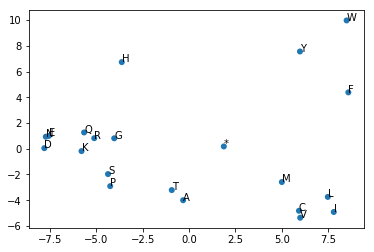

In [43]:
fig, ax = plt.subplots()
plt.scatter(blosum_pca[:, 0], blosum_pca[:, 1], edgecolor='none')

for i, txt in enumerate(rows):
    ax.annotate(txt, (blosum_pca[:, 0][i], blosum_pca[:, 1][i]))
    

plt.show()

In [44]:
v = blosum[:, :]   # foo[:, -1] for the last column
blosum[:, :] = (v - v.min()) / (v.max() - v.min())

In [45]:
blosum_dict = {}
for i in range(len(rows)):
    blosum_dict[rows[i]]= blosum[i]

In [46]:
blosum_dict

{'A': array([0.53333333, 0.2       , 0.13333333, 0.13333333, 0.26666667,
        0.2       , 0.2       , 0.26666667, 0.13333333, 0.2       ,
        0.2       , 0.2       , 0.2       , 0.13333333, 0.2       ,
        0.33333333, 0.26666667, 0.06666667, 0.13333333, 0.26666667,
        0.        ]),
 'R': array([0.2       , 0.6       , 0.26666667, 0.13333333, 0.06666667,
        0.33333333, 0.26666667, 0.13333333, 0.26666667, 0.06666667,
        0.13333333, 0.4       , 0.2       , 0.06666667, 0.13333333,
        0.2       , 0.2       , 0.06666667, 0.13333333, 0.06666667,
        0.        ]),
 'N': array([0.13333333, 0.26666667, 0.66666667, 0.33333333, 0.06666667,
        0.26666667, 0.26666667, 0.26666667, 0.33333333, 0.06666667,
        0.06666667, 0.26666667, 0.13333333, 0.06666667, 0.13333333,
        0.33333333, 0.26666667, 0.        , 0.13333333, 0.06666667,
        0.        ]),
 'D': array([0.13333333, 0.13333333, 0.33333333, 0.66666667, 0.06666667,
        0.26666667, 0.4       

# LSTM with Keras 

In [47]:
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.optimizers import Adam, Nadam
np.random.seed(1)

Using TensorFlow backend.


In [48]:
def pretrained_embedding_layer(blosum_dict, aa_to_int):
    """
    Creates a Keras Embedding() layer based on Blosum62
    
    Arguments:
    blosum_dict -- dictionary mapping aa to their Blosum62 representation.
    aa_to_int -- dictionary mapping from amino acid to their indices 

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    aa_len = len(aa_to_int) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = blosum_dict["A"].shape[0]      # define dimensionality of your blosum vectors 
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (aa_len, dimensions of aa vectors = emb_dim)
    emb_matrix = np.zeros([aa_len,emb_dim])
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for aa, index in aa_to_int.items():
        emb_matrix[index, :] = blosum_dict[aa]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(aa_len, emb_dim, trainable=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [49]:
embedding_layer = pretrained_embedding_layer(blosum_dict, aa_to_int)

Instructions for updating:
Colocations handled automatically by placer.


## MODEL

In [ ]:
   X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

In [77]:
def Loc_predict(input_shape, blosum_dict, aa_to_int):
    """
    Function creating the a protein localization prediction model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    blosum_dict -- dictionary mapping everyaa into its blosum vector representation
    aa_to_int -- dictionary mapping from aa to their indices 
    
    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    aa_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(blosum_dict, aa_to_int)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(aa_indices)
    #embeddings = Embedding(input_shape, 30)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    #X =  LSTM(64, return_sequences=True)(embeddings)
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    #X = Dropout(0.1)(X)
    
    #X = LSTM(64, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.2)(X)
    #X = Dense(64, activation='relu')(X)
    # X = Dense(128, activation='relu')(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(tot_cat, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[aa_indices], outputs=[X])
    
    ### END CODE HERE ###
    
    return model

In [78]:
model = Loc_predict((max_len,), blosum_dict, aa_to_int)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1501)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1501, 21)          462       
_________________________________________________________________
lstm_8 (LSTM)                (None, 1501, 128)         76800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1501, 128)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387 

In [64]:
from keras.metrics import categorical_accuracy

In [79]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [66]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)
d_class_weights = dict(enumerate(class_weights))

In [80]:
#, class_weight=d_class_weights
model.fit(train_indices, train_y_OH, epochs = 25, batch_size = 64, shuffle=True)

Epoch 1/25
4446/4446 [==============================] - 427s 96ms/step - loss: 1.0403 - accuracy: 0.4600
Epoch 2/25
4446/4446 [==============================] - 395s 89ms/step - loss: 1.0337 - accuracy: 0.4737
Epoch 3/25
4446/4446 [==============================] - 401s 90ms/step - loss: 1.0328 - accuracy: 0.4737
Epoch 4/25
4446/4446 [==============================] - 365s 82ms/step - loss: 1.0333 - accuracy: 0.4737
Epoch 5/25
4446/4446 [==============================] - 361s 81ms/step - loss: 1.0325 - accuracy: 0.4737
Epoch 6/25
4446/4446 [==============================] - 367s 83ms/step - loss: 1.0326 - accuracy: 0.4737
Epoch 7/25
4446/4446 [==============================] - 364s 82ms/step - loss: 1.0320 - accuracy: 0.4737
Epoch 8/25
4446/4446 [==============================] - 363s 82ms/step - loss: 1.0328 - accuracy: 0.4737
Epoch 9/25
4446/4446 [==============================] - 362s 82ms/step - loss: 1.0346 - accuracy: 0.4737
Epoch 10/25
4446/4446 [==============================] 

In [82]:
# Accuracy = 0.326 for several epoch, no further improvment
loss, acc = model.evaluate(test_indices, test_y_OH)
print()
print("Test accuracy = ", acc)

1112/1112 [==============================] - 41s 37ms/step

Test accuracy =  0.4739208519458771


In [70]:
model.save("3Classes_model1.h5")

In [72]:
y_pred = model.predict(test_indices)
#should be array#
#matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
y_pred

array([[0.323337  , 0.23053128, 0.44613174],
       [0.323337  , 0.23053128, 0.44613174],
       [0.323337  , 0.23053128, 0.44613174],
       ...,
       [0.323337  , 0.23053128, 0.44613174],
       [0.323337  , 0.23053128, 0.44613174],
       [0.32333702, 0.23053128, 0.44613174]], dtype=float32)

In [73]:
test_y_OH

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [81]:
test_y_indices

array([2, 2, 0, ..., 0, 2, 2])

In [ ]:
# One hot to label 
Y is list of OH vector
def OH_to_label_indices(Y)
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [75]:
y_pred.shape

(1112, 3)

In [76]:
test_y_OH.shape

(1112, 3)